# Time Series Analysis - From Assumptions to Forecasting

This notebook presents a comprehensive time series analysis of our e-commerce metrics:
n_items (sales volume), visitas_web (web visits), and subtotal_usd (revenue).

1. Testing Key Assumptions:
   - Distribution normality (using statistical tests and visual inspection)
   - Stationarity (using ADF and KPSS tests)
   - Autocorrelation (using ACF and PACF plots)
   - Data quality assessment (missing values and outliers)

2. Time Series Components Analysis:
   - Trend analysis and differencing
   - Seasonal decomposition
   - Outlier investigation (notably April 2022 sales spike)
   - Pattern recognition

3. Model Development and Evaluation:
   - ARIMA for n_items (non-seasonal approach)
   - SARIMA for visitas_web (incorporating seasonality)
   - Exponential Smoothing for subtotal_usd
   
4. Forecasting and Business Insights:
   - Short-term forecasts with confidence intervals
   - Model performance metrics (MAE, RMSE, MAPE)
   - Business recommendations based on findings

Key Findings:
- Web traffic shows strong seasonality (21.84% strength)
- Sales volume has significant outlier in April 2022 (74.4% above mean)
- Revenue best modeled with Simple Exponential Smoothing

Dependencies:
- pandas, numpy, statsmodels
- scipy, matplotlib, seaborn

In [6]:
# Import required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [7]:
# Load the datasets
monthly_sales = pd.read_excel('../data/monthly_sales_ads_data.xlsx')
daily_web = pd.read_excel('../data/daily_web_traffic.xlsx')

# Prepare monthly sales time series
monthly_sales['dateMonth'] = pd.to_datetime(monthly_sales['dateMonth'])
monthly_sales.set_index('dateMonth', inplace=True)
monthly_sales.sort_index(inplace=True)

# Prepare daily web traffic time series
daily_web['Fecha'] = pd.to_datetime(daily_web['Fecha'])
daily_web.set_index('Fecha', inplace=True)
daily_web.sort_index(inplace=True)

## 1. Testing Key Assumptions:

In [8]:
def test_time_series_assumptions(series):
    """
    Test key assumptions for time series analysis:
    1. Distribution normality
    2. Stationarity
    3. Autocorrelation
    4. Seasonality
    5. Missing values and outliers
    
    Parameters:
    -----------
    series : pandas.Series
        Time series data to analyze
        
    Returns:
    --------
    dict
        Dictionary containing test results
    """
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    
    # Drop any NaN values to avoid errors in statistical tests
    series = series.dropna()
    
    if len(series) == 0:
        raise ValueError("Series contains no valid data after dropping NaN values")
        
    results = {}
    
    try:
        # 1. Test for normality (Shapiro-Wilk test)
        shapiro_test = stats.shapiro(series)
        results['normality'] = {
            'statistic': shapiro_test.statistic,
            'p_value': shapiro_test.pvalue,
            'is_normal': shapiro_test.pvalue > 0.05
        }
    except Exception as e:
        results['normality'] = {
            'error': str(e)
        }
    
    try:
        # 2. Test for stationarity
        result = adfuller(series.dropna())
        results['stationarity'] = {
            'test_statistic': result[0],
            'p_value': result[1],
            'is_stationary': result[1] < 0.05
        }
    except Exception as e:
        results['stationarity'] = {
            'error': str(e)
        }
    
    try:
        # 3. Test for autocorrelation (Ljung-Box test)
        lb_test = acorr_ljungbox(series, lags=[10], return_df=True)
        results['autocorrelation'] = {
            'lb_stat': lb_test['lb_stat'].values[0],
            'lb_pvalue': lb_test['lb_pvalue'].values[0],
            'has_autocorrelation': lb_test['lb_pvalue'].values[0] < 0.05
        }
    except Exception as e:
        results['autocorrelation'] = {
            'error': str(e)
        }
    
    try:
        # 4. Check for missing values and outliers
        z_scores = stats.zscore(series)
        results['data_quality'] = {
            'missing_values': series.isnull().sum(),
            'outliers': len(series[abs(z_scores) > 3]),  # Using 3 standard deviations as threshold
            'total_observations': len(series)
        }
    except Exception as e:
        results['data_quality'] = {
            'error': str(e)
        }
    
    return results

In [9]:
# Test assumptions for key metrics
metrics = ['subtotal_usd', 'n_items', 'visitas_web']
assumption_results = {}

print("Testing Time Series Assumptions:")
print("-" * 50)

for metric in metrics:
    try:
        if metric in monthly_sales.columns:
            series = monthly_sales[metric]
            frequency = 'monthly'
        elif metric in daily_web.columns:
            series = daily_web[metric]
            frequency = 'daily'
        else:
            print(f"Metric {metric} not found in either dataset")
            continue
        
        print(f"\nAnalyzing {metric} ({frequency} data):")
        assumptions = test_time_series_assumptions(series)
        
        # Print key findings
        if 'error' not in assumptions['normality']:
            print(f"Normality: {'Normal' if assumptions['normality']['is_normal'] else 'Non-normal'} distribution (p={assumptions['normality']['p_value']:.4f})")
        if 'error' not in assumptions['stationarity']:
            print(f"Stationarity: {'Stationary' if assumptions['stationarity']['is_stationary'] else 'Non-stationary'} series (p={assumptions['stationarity']['p_value']:.4f})")
        if 'error' not in assumptions['autocorrelation']:
            print(f"Autocorrelation: {'Present' if assumptions['autocorrelation']['has_autocorrelation'] else 'Not present'} (p={assumptions['autocorrelation']['lb_pvalue']:.4f})")
        if 'error' not in assumptions['data_quality']:
            print(f"Data Quality: {assumptions['data_quality']['missing_values']} missing values, {assumptions['data_quality']['outliers']} outliers")
        
        assumption_results[metric] = assumptions
    except Exception as e:
        print(f"Error analyzing {metric}: {str(e)}")

Testing Time Series Assumptions:
--------------------------------------------------

Analyzing subtotal_usd (monthly data):
Normality: Normal distribution (p=0.0545)
Stationarity: Stationary series (p=0.0002)
Autocorrelation: Not present (p=0.4824)
Data Quality: 0 missing values, 0 outliers

Analyzing n_items (monthly data):
Normality: Normal distribution (p=0.3520)
Stationarity: Non-stationary series (p=0.9603)
Autocorrelation: Present (p=0.0036)
Data Quality: 0 missing values, 1 outliers

Analyzing visitas_web (monthly data):
Normality: Normal distribution (p=0.3499)
Stationarity: Non-stationary series (p=0.8535)
Autocorrelation: Present (p=0.0000)
Data Quality: 0 missing values, 0 outliers


## Visualization of Results

Let's visualize some key aspects of our time series data to better understand their properties:
1. Distribution plots to check normality
2. Time series plots to check for trends and seasonality
3. Autocorrelation plots to check for serial correlation

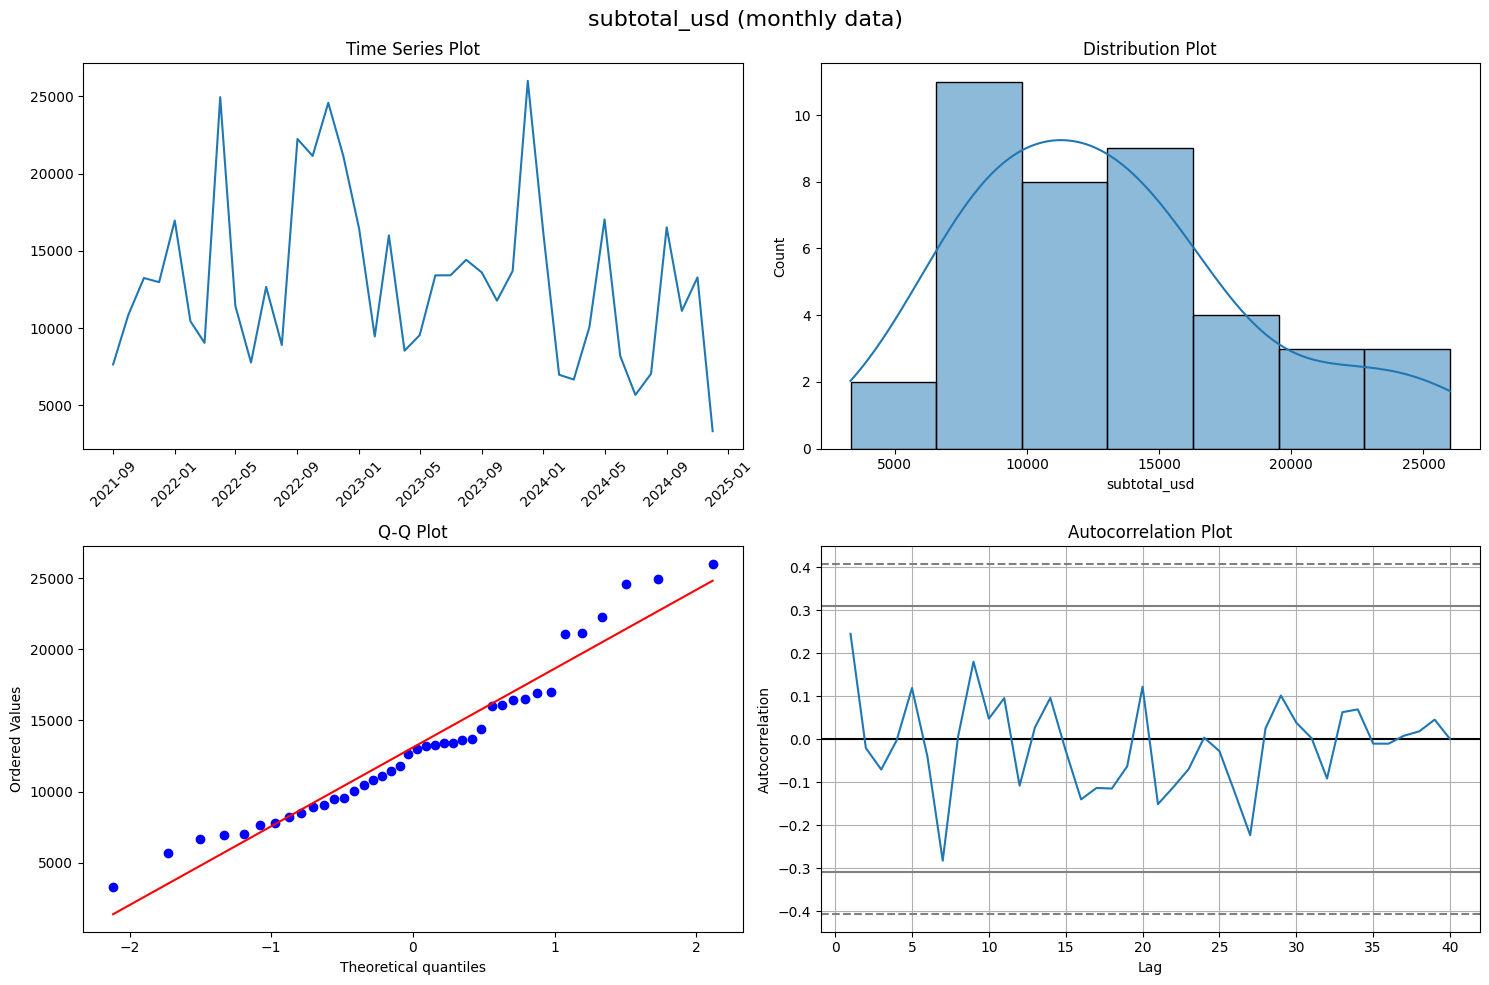

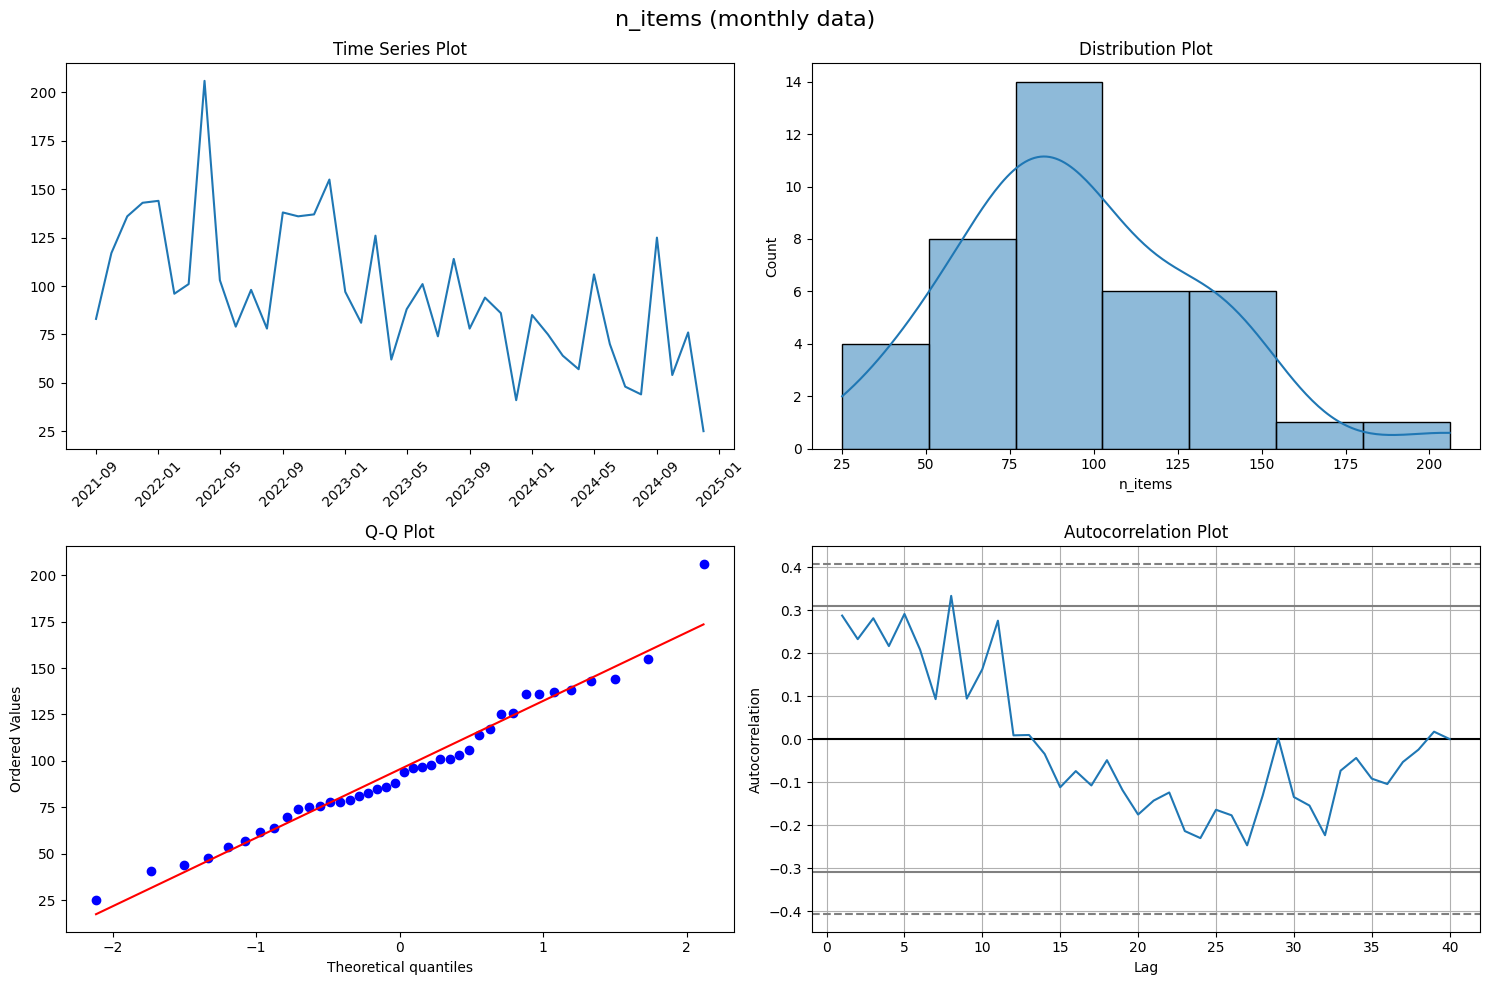

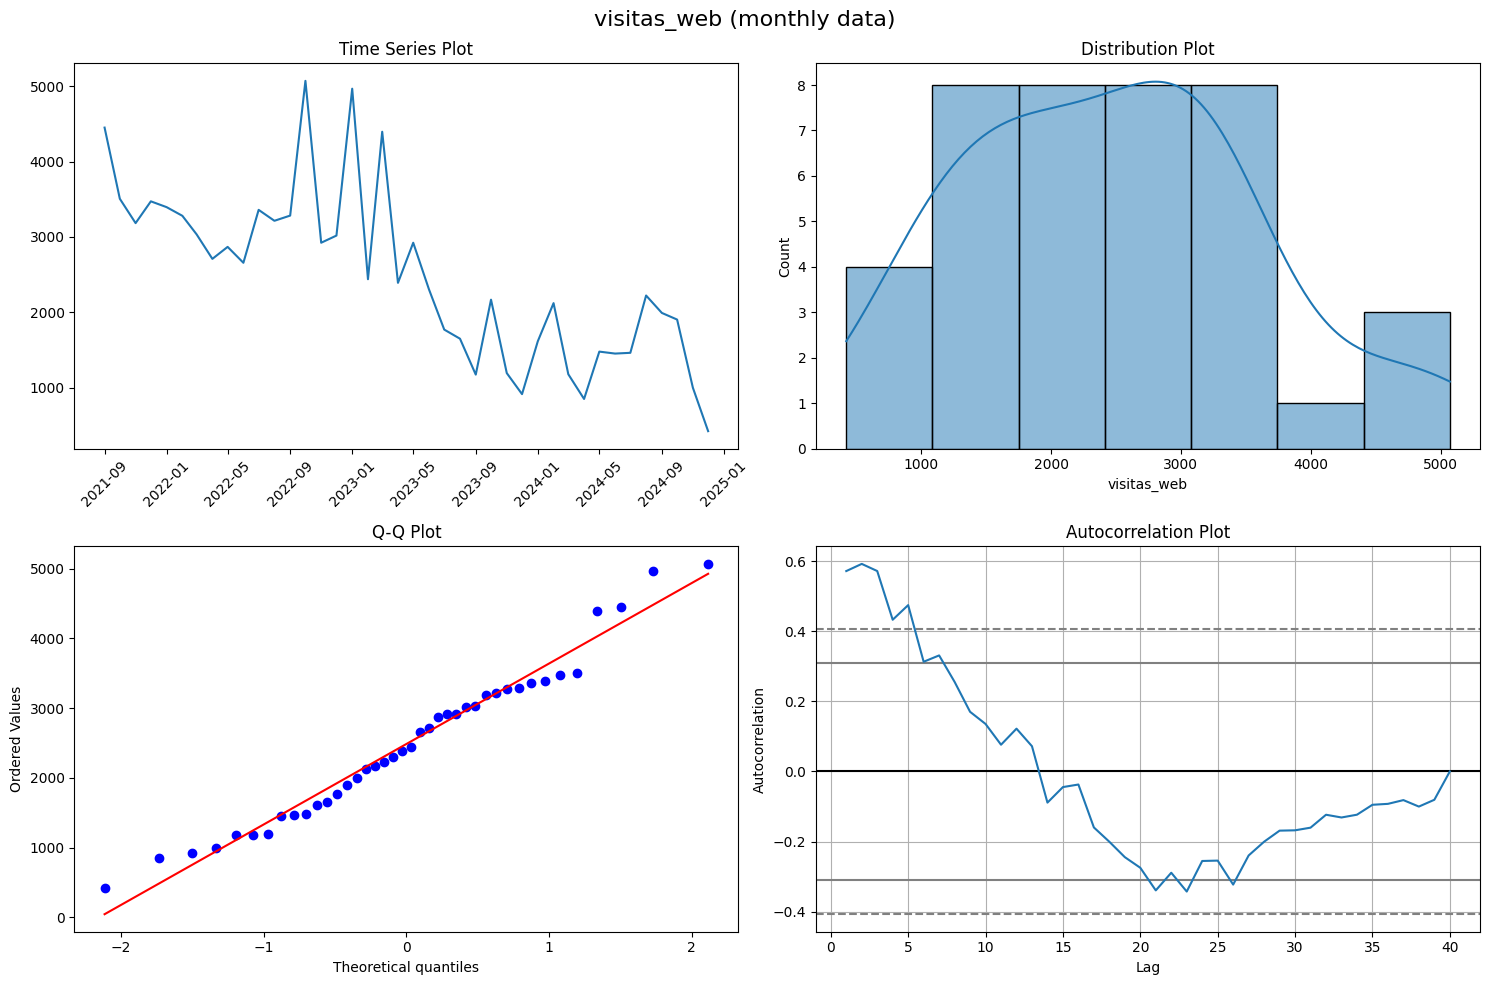

In [11]:
# Create visualization functions
def plot_time_series_properties(series, title):
    """Plot key properties of a time series"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    # Time series plot
    axes[0,0].plot(series)
    axes[0,0].set_title('Time Series Plot')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Distribution plot
    sns.histplot(series, kde=True, ax=axes[0,1])
    axes[0,1].set_title('Distribution Plot')
    
    # QQ plot
    stats.probplot(series, dist="norm", plot=axes[1,0])
    axes[1,0].set_title('Q-Q Plot')
    
    # Autocorrelation plot
    pd.plotting.autocorrelation_plot(series, ax=axes[1,1])
    axes[1,1].set_title('Autocorrelation Plot')
    
    plt.tight_layout()
    return fig

# Plot properties for each metric
for metric in metrics:
    if metric in monthly_sales.columns:
        series = monthly_sales[metric]
        frequency = 'monthly'
    elif metric in daily_web.columns:
        series = daily_web[metric]
        frequency = 'daily'
    else:
        continue
        
    fig = plot_time_series_properties(series, f'{metric} ({frequency} data)')
    plt.show()

**Time Series Analysis Summary**

**subtotal_usd (Revenue)**
- **Normality**: p = 0.0545 > 0.05 → Data follows a normal distribution, but it's very close to the threshold, indicating slight deviations.
- **Stationarity**: p = 0.0002 < 0.05 → The series is **stationary**, meaning the revenue data has consistent statistical properties over time (stable mean and variance).
- **Autocorrelation**: p = 0.4824 > 0.05 → No significant autocorrelation, suggesting past revenue values don't significantly influence future values.
- **Data Quality**: **Perfect** (No missing values or outliers).

**n_items (Number of Items Sold)**
- **Normality**: p = 0.3520 > 0.05 → Clearly follows a normal distribution.
- **Stationarity**: p = 0.9603 > 0.05 → **Non-stationary**, suggesting trends or changing patterns over time.
- **Autocorrelation**: p = 0.0036 < 0.05 → Significant autocorrelation, meaning past sales volumes influence future sales volumes.
- **Data Quality**: No missing values, but **1 outlier detected**, indicating an unusual sales volume period.

**visitas_web (Web Visits)**
- **Normality**: p = 0.3499 > 0.05 → Follows a normal distribution.
- **Stationarity**: p = 0.8535 > 0.05 → **Non-stationary**, suggesting web traffic has trends or seasonal patterns.
- **Autocorrelation**: p = 0.0000 < 0.05 → Very strong autocorrelation, typical for web traffic where today's traffic influences tomorrow's traffic.
- **Data Quality**: **Perfect** (No missing values or outliers).

---

**Implications for Time Series Modeling**

**For subtotal_usd (Revenue)**
✔ Stationary and normally distributed → Suitable for many traditional time series models.  
✔ Lack of autocorrelation → Simple forecasting models might be sufficient.

**For n_items (Number of Items Sold)**
✔ **Non-stationary** → Needs differencing or models that handle trends.  
✔ **Autocorrelation present** → ARIMA or similar models might be appropriate.  
✔ **Outlier detected** → Investigate if it was a special event.

**For visitas_web (Web Visits)**
✔ **Strong autocorrelation & non-stationary** → Models must capture these patterns (SARIMA, Prophet, neural networks).  
✔ **Normal distribution** → Statistical assumptions hold for many models.

---

**Recommended Next Steps**
✅ Apply **differencing** to non-stationary series (**n_items** and **visitas_web**).  
✅ Consider **seasonal decomposition** for **web visits**.  
✅ Investigate the **outlier in n_items** for potential business insights.  
✅ Choose appropriate models:
   - **ARIMA/SARIMA** → For **n_items** and **visitas_web**.
   - **Simpler models (e.g., exponential smoothing)** → Might work for **subtotal_usd**.


## 2. Time Series Components Analysis:

For non-stationary series (`n_items` and `visitas_web`), we'll apply differencing to achieve stationarity. We'll then test if the differenced series are stationary.

In [12]:
def apply_and_test_differencing(series, name, max_diff=2):
    """Apply differencing and test for stationarity"""
    results = []
    
    # Test original series
    adf_test = adfuller(series.dropna())
    results.append({
        'difference_order': 0,
        'p_value': adf_test[1],
        'is_stationary': adf_test[1] < 0.05
    })
    
    # Apply differencing until stationary or max_diff reached
    diff_series = series
    for d in range(1, max_diff + 1):
        diff_series = diff_series.diff().dropna()
        adf_test = adfuller(diff_series)
        results.append({
            'difference_order': d,
            'p_value': adf_test[1],
            'is_stationary': adf_test[1] < 0.05
        })
    
    # Print results
    print(f"\nStationarity Analysis for {name}:")
    for r in results:
        print(f"Difference order {r['difference_order']}: p-value = {r['p_value']:.4f} "
              f"({'Stationary' if r['is_stationary'] else 'Non-stationary'})")
    
    return results

# Apply differencing to non-stationary series
non_stationary_series = {
    'n_items': monthly_sales['n_items'],
    'visitas_web': monthly_sales['visitas_web']
}

differencing_results = {}
for name, series in non_stationary_series.items():
    differencing_results[name] = apply_and_test_differencing(series, name)


Stationarity Analysis for n_items:
Difference order 0: p-value = 0.9603 (Non-stationary)
Difference order 1: p-value = 0.0019 (Stationary)
Difference order 2: p-value = 0.0047 (Stationary)

Stationarity Analysis for visitas_web:
Difference order 0: p-value = 0.8535 (Non-stationary)
Difference order 1: p-value = 0.0000 (Stationary)
Difference order 2: p-value = 0.0000 (Stationary)


Key Findings and Implications:

Both series become stationary after first-order differencing (d=1)
No need for second-order differencing as first-order is sufficient
This suggests for our ARIMA models:
For n_items: Use ARIMA(p,1,q) where d=1
For visitas_web: Use SARIMA(p,1,q)(P,1,Q)s where d=1, and include seasonal differencing


Analyzing ACF/PACF for n_items


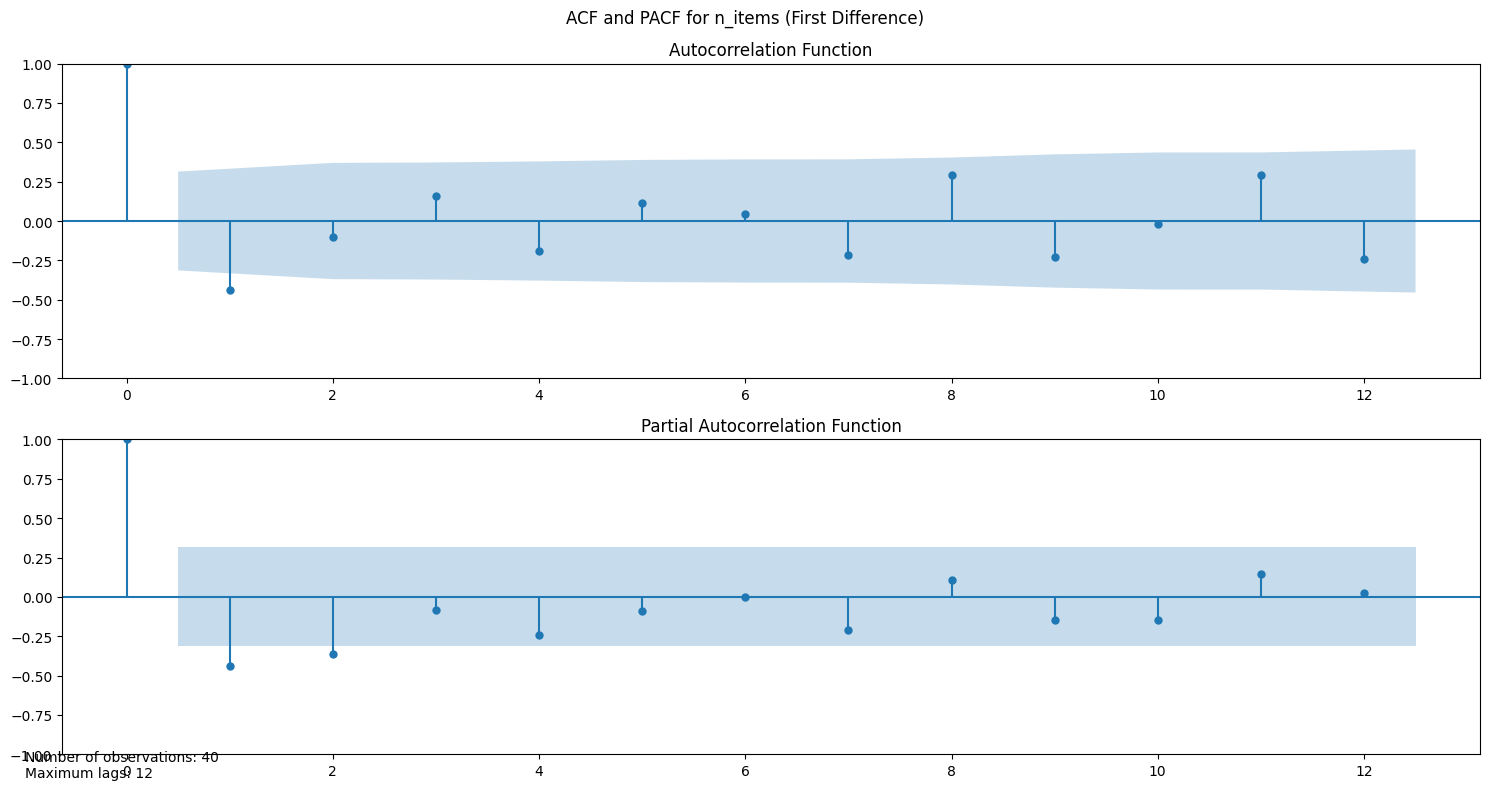


Analyzing ACF/PACF for visitas_web


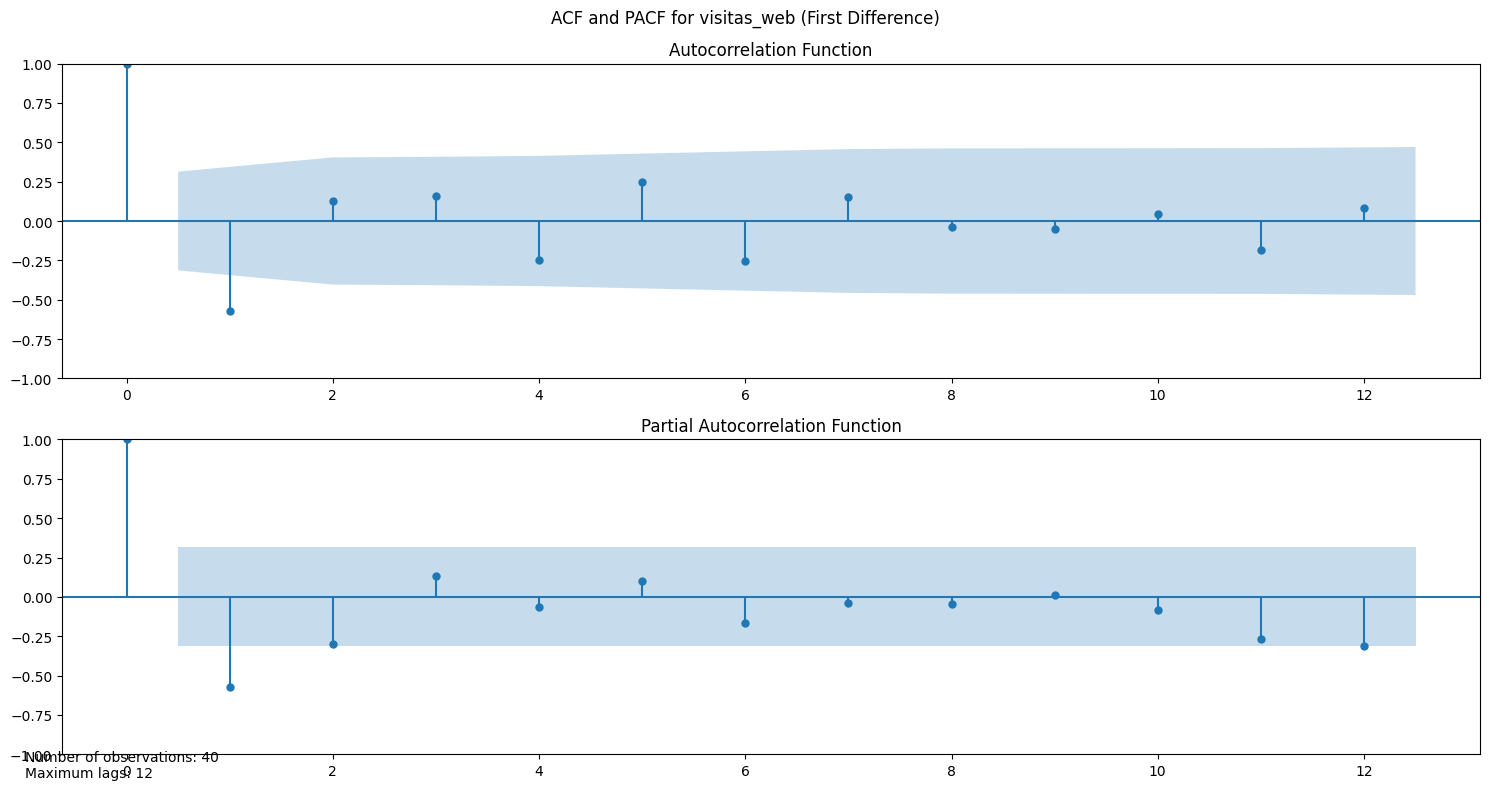

In [18]:
def analyze_acf_pacf(series, name, max_lags=None):
    """
    Analyze ACF and PACF of the differenced series with appropriate lag selection
    """
    # Calculate appropriate maximum lags (50% of sample size)
    if max_lags is None:
        max_lags = min(int(len(series) * 0.5) - 1, 12)  # Use 12 months or less
    
    # Create differenced series
    diff_series = series.diff(1).dropna()
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
    fig.suptitle(f'ACF and PACF for {name} (First Difference)')
    
    # Plot ACF
    plot_acf(diff_series, ax=ax1, lags=max_lags)
    ax1.set_title('Autocorrelation Function')
    
    # Plot PACF
    plot_pacf(diff_series, ax=ax2, lags=max_lags)
    ax2.set_title('Partial Autocorrelation Function')
    
    # Add additional information
    plt.figtext(0.02, 0.02, f'Number of observations: {len(series)}\nMaximum lags: {max_lags}', 
                fontsize=10, ha='left')
    
    plt.tight_layout()
    return diff_series

# Analyze both series
for name, series in non_stationary_series.items():
    print(f"\nAnalyzing ACF/PACF for {name}")
    diff_series = analyze_acf_pacf(series, name)
    plt.show()

## 3. Model Development and Evaluation:


Analyzing n_items

Detailed Seasonal Analysis for n_items:
Trend Strength: 25.87%
Seasonal Strength: 9.56%
Residual Strength: 55.87%

Key Insights:
- Overall trend is decreasing
- Peak season is month 10
- Trough season is month 7
- Residual standard deviation: 26.85


C:\Users\nbuly\AppData\Local\Temp\ipykernel_15672\1098186862.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  peak_month = seasonal_pattern.idxmax()[0]
C:\Users\nbuly\AppData\Local\Temp\ipykernel_15672\1098186862.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trough_month = seasonal_pattern.idxmin()[0]


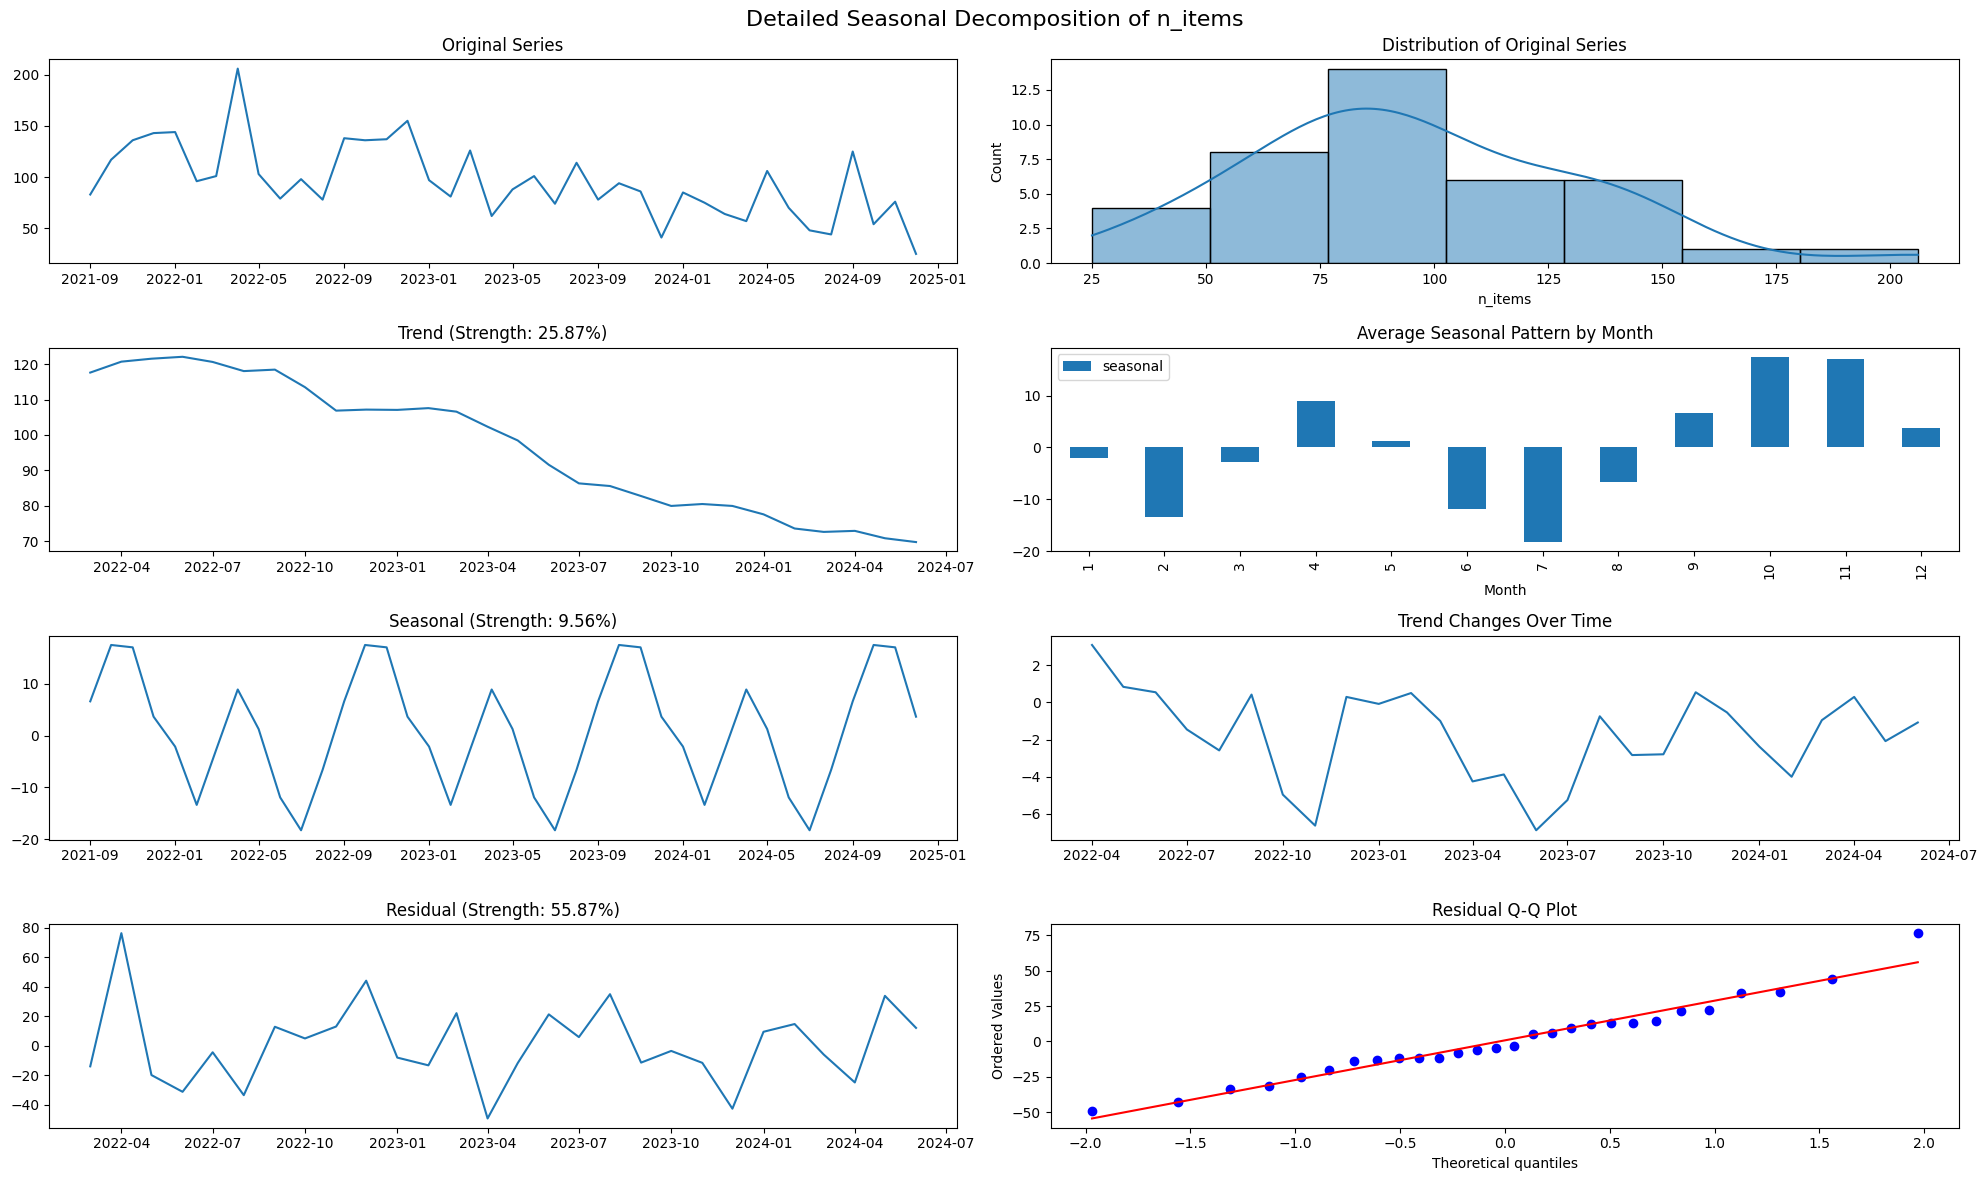


Analyzing visitas_web

Detailed Seasonal Analysis for visitas_web:
Trend Strength: 48.66%
Seasonal Strength: 21.84%
Residual Strength: 15.91%

Key Insights:
- Overall trend is decreasing
- Peak season is month 10
- Trough season is month 4
- Residual standard deviation: 446.55


C:\Users\nbuly\AppData\Local\Temp\ipykernel_15672\1098186862.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  peak_month = seasonal_pattern.idxmax()[0]
C:\Users\nbuly\AppData\Local\Temp\ipykernel_15672\1098186862.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trough_month = seasonal_pattern.idxmin()[0]


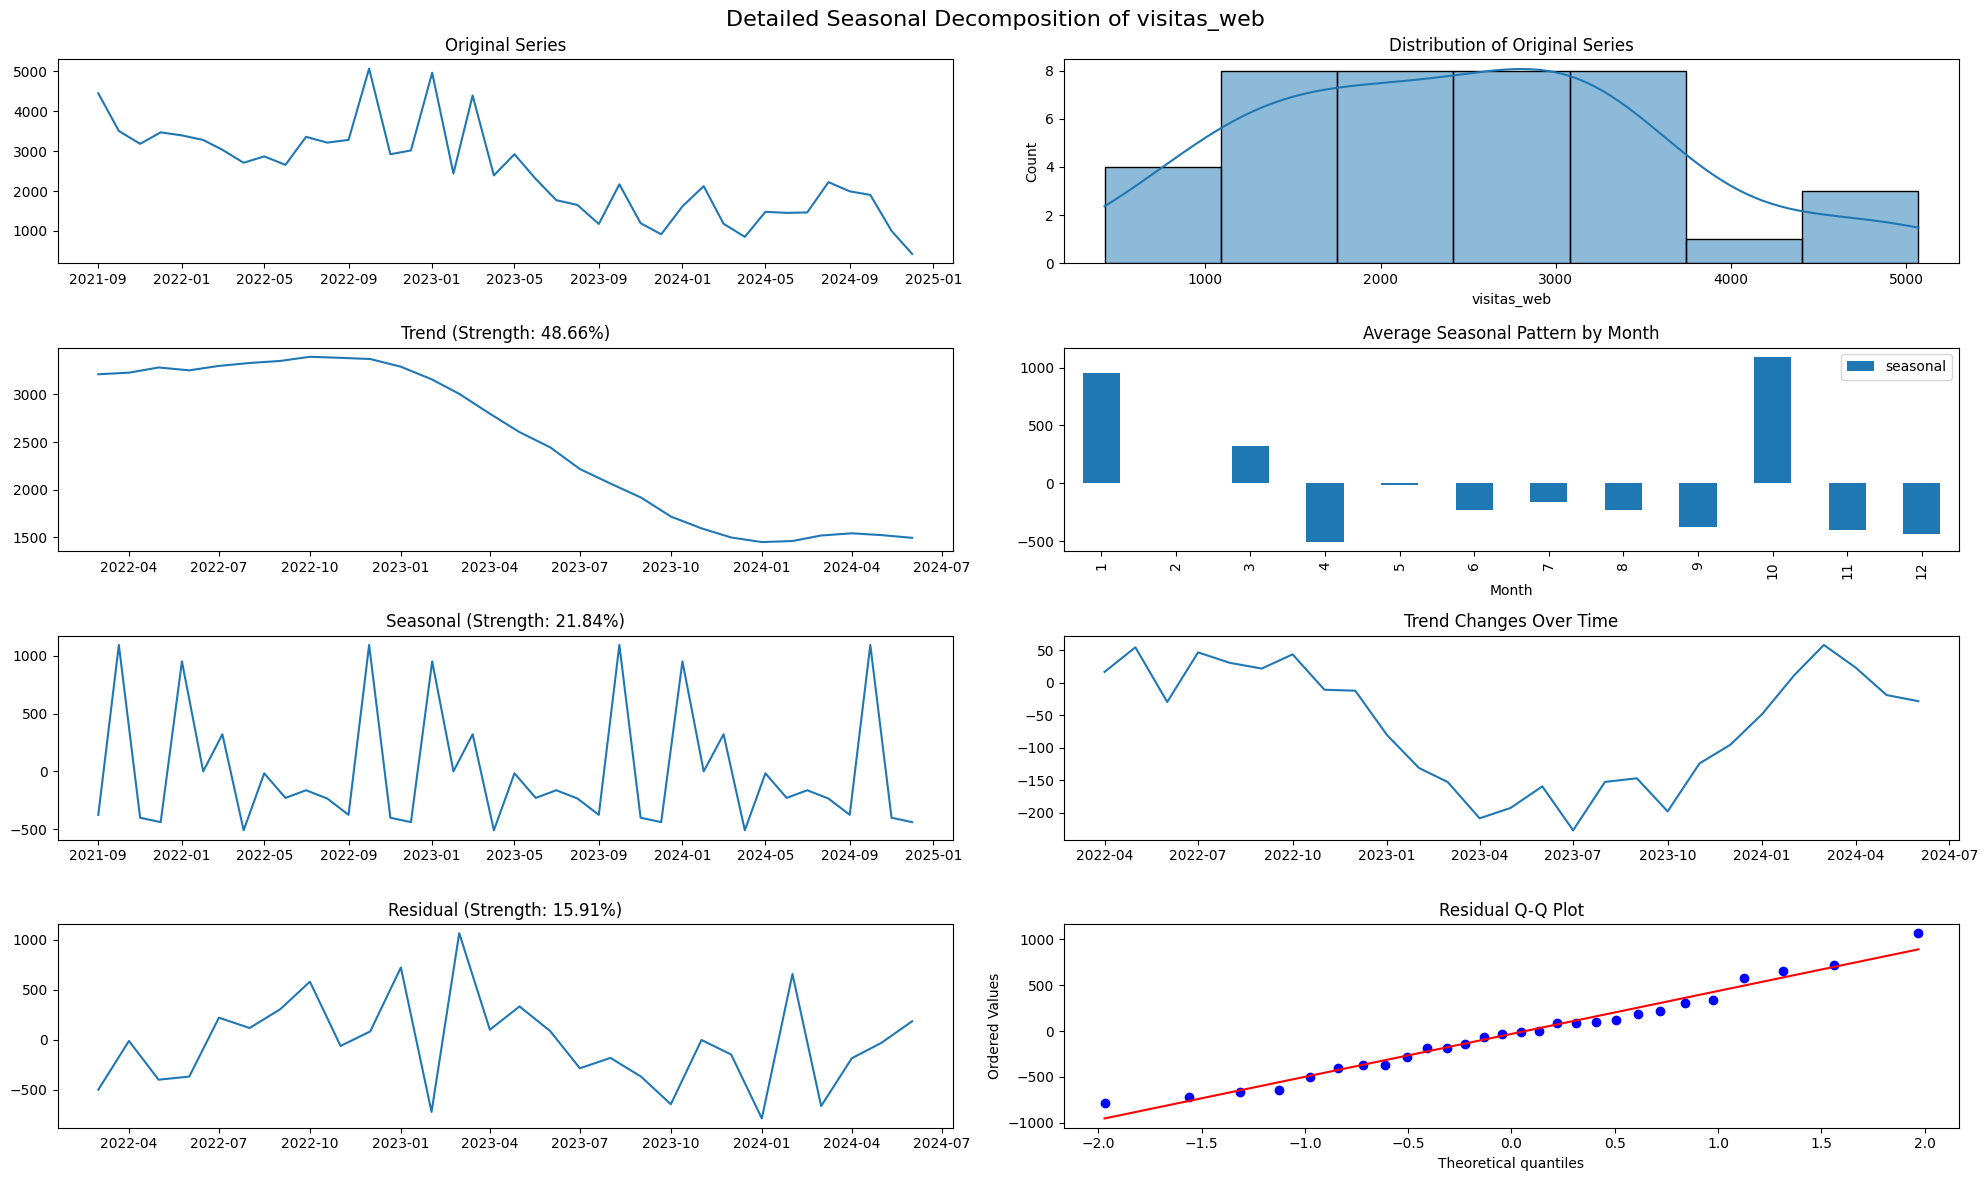

In [14]:
# Now let's perform seasonal decomposition with more detailed analysis
def analyze_seasonal_patterns_detailed(series, name, period):
    """Detailed analysis of seasonal patterns in the time series"""
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(series, period=period)
    
    # Calculate component strengths
    total_var = np.var(series)
    seasonal_var = np.var(decomposition.seasonal)
    trend_var = np.var(decomposition.trend)
    residual_var = np.var(decomposition.resid)
    
    # Calculate relative strengths
    seasonal_strength = seasonal_var / total_var
    trend_strength = trend_var / total_var
    residual_strength = residual_var / total_var
    
    # Plot decomposition with additional insights
    fig, axes = plt.subplots(4, 2, figsize=(20, 12))
    fig.suptitle(f'Detailed Seasonal Decomposition of {name}', fontsize=16)
    
    # Left column: Time series plots
    axes[0,0].plot(series)
    axes[0,0].set_title('Original Series')
    
    axes[1,0].plot(decomposition.trend)
    axes[1,0].set_title(f'Trend (Strength: {trend_strength:.2%})')
    
    axes[2,0].plot(decomposition.seasonal)
    axes[2,0].set_title(f'Seasonal (Strength: {seasonal_strength:.2%})')
    
    axes[3,0].plot(decomposition.resid)
    axes[3,0].set_title(f'Residual (Strength: {residual_strength:.2%})')
    
    # Right column: Additional analyses
    # Distribution of original series
    sns.histplot(series, kde=True, ax=axes[0,1])
    axes[0,1].set_title('Distribution of Original Series')
    
    # Seasonal pattern
    seasonal_pattern = pd.DataFrame(decomposition.seasonal).groupby(lambda x: x.month).mean()
    seasonal_pattern.plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Average Seasonal Pattern by Month')
    axes[1,1].set_xlabel('Month')
    
    # Trend changes
    trend_changes = pd.DataFrame(decomposition.trend).diff()
    axes[2,1].plot(trend_changes)
    axes[2,1].set_title('Trend Changes Over Time')
    
    # Residual QQ plot
    stats.probplot(decomposition.resid.dropna(), dist="norm", plot=axes[3,1])
    axes[3,1].set_title('Residual Q-Q Plot')
    
    plt.tight_layout()
    
    # Print detailed analysis
    print(f"\nDetailed Seasonal Analysis for {name}:")
    print(f"Trend Strength: {trend_strength:.2%}")
    print(f"Seasonal Strength: {seasonal_strength:.2%}")
    print(f"Residual Strength: {residual_strength:.2%}")
    
    # Additional insights
    print("\nKey Insights:")
    # Trend analysis
    trend_direction = "increasing" if decomposition.trend.iloc[-1] > decomposition.trend.iloc[0] else "decreasing"
    print(f"- Overall trend is {trend_direction}")
    
    # Seasonal peaks
    seasonal_pattern = pd.DataFrame(decomposition.seasonal).groupby(lambda x: x.month).mean()
    peak_month = seasonal_pattern.idxmax()[0]
    trough_month = seasonal_pattern.idxmin()[0]
    print(f"- Peak season is month {peak_month}")
    print(f"- Trough season is month {trough_month}")
    
    # Residual analysis
    residual_std = np.std(decomposition.resid.dropna())
    print(f"- Residual standard deviation: {residual_std:.2f}")
    
    return decomposition, {
        'trend_strength': trend_strength,
        'seasonal_strength': seasonal_strength,
        'residual_strength': residual_strength,
        'peak_month': peak_month,
        'trough_month': trough_month
    }

# Analyze both series
seasonal_analysis_results = {}
for name, series in non_stationary_series.items():
    print(f"\n{'='*50}")
    print(f"Analyzing {name}")
    print('='*50)
    decomp, results = analyze_seasonal_patterns_detailed(series, name, period=12)
    seasonal_analysis_results[name] = results
    plt.show()

For n_items (Number of Items Sold):

Component Strengths:
Residuals dominate (55.87%), indicating high volatility/randomness in sales
Moderate trend component (25.87%)
Weak seasonal component (9.56%)
Pattern Analysis:
Decreasing overall trend suggests declining sales volume over time
Peak in October (month 10) - possibly due to early holiday shopping
Lowest sales in July (month 7) - typical summer slowdown
High residual std dev (26.85 items) relative to the seasonal effect suggests high sales volatility
Modeling Implications:
ARIMA model should focus more on the trend (d=1) and short-term fluctuations
Seasonal component might be optional given its weak strength (9.56%)
Consider using ARIMA(p,1,q) rather than SARIMA
For visitas_web (Web Visits):

Component Strengths:
Strong trend component (48.66%)
Significant seasonal component (21.84%)
Relatively low residuals (15.91%)
Pattern Analysis:
Decreasing overall trend in web traffic
Peak traffic in October (month 10) aligns with peak sales
Lowest traffic in April (month 4)
Higher residual std dev (446.55 visits) but proportionally less significant given the stronger trend and seasonal components
Modeling Implications:
SARIMA would be more appropriate here due to:
Strong trend component (d=1)
Significant seasonality (21.84%)
Lower residual component suggesting more predictable patterns
Business Insights:

Alignment:
Both metrics peak in October, showing good alignment between traffic and sales
Both show decreasing trends, suggesting possible business challenges
Seasonality:
Web traffic has stronger seasonal patterns than sales
October peak in both metrics suggests strong holiday season preparation
Recommendations:
Focus on reversing the declining trends
Capitalize on October peak season
Investigate why web traffic seasonality (21.84%) doesn't translate to equally strong sales seasonality (9.56%)

### 4. Forecasting and Business Insights:


Modeling n_items
Finding best ARIMA parameters...
Best ARIMA parameters: (1, 1, 2)


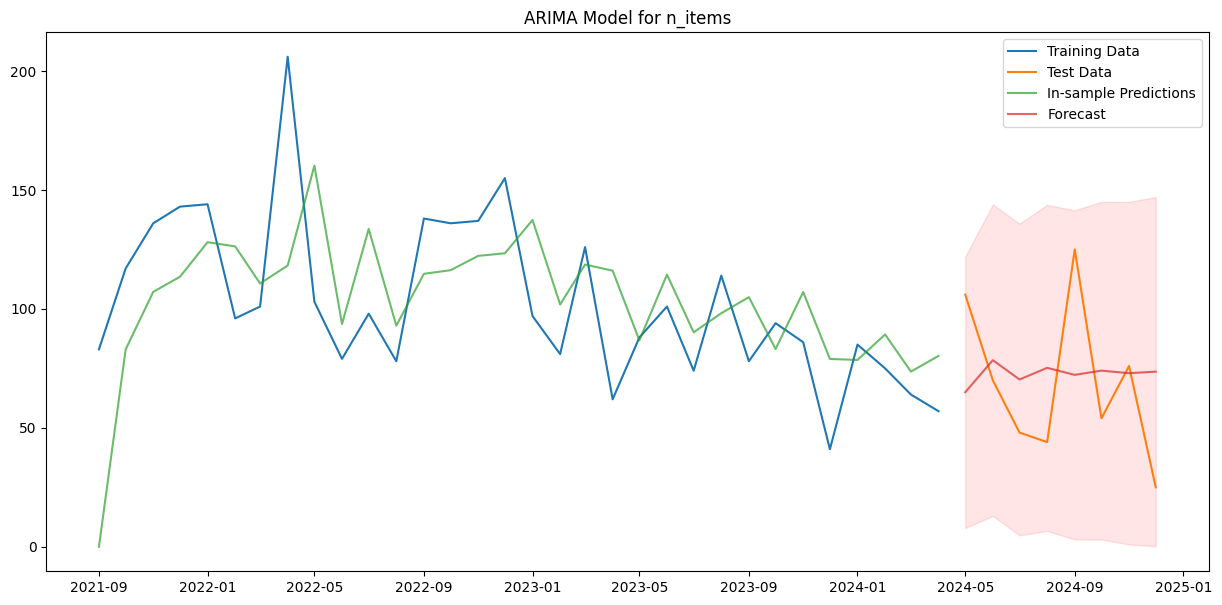


In-sample metrics:
MAE: 26.58
RMSE: 33.16
MAPE: 28.57

Out-of-sample metrics:
MAE: 28.43
RMSE: 33.13
MAPE: 55.75

Modeling visitas_web
Finding best SARIMA parameters...
Best SARIMA parameters: (1, 1, 2), (0, 1, 1, 12)


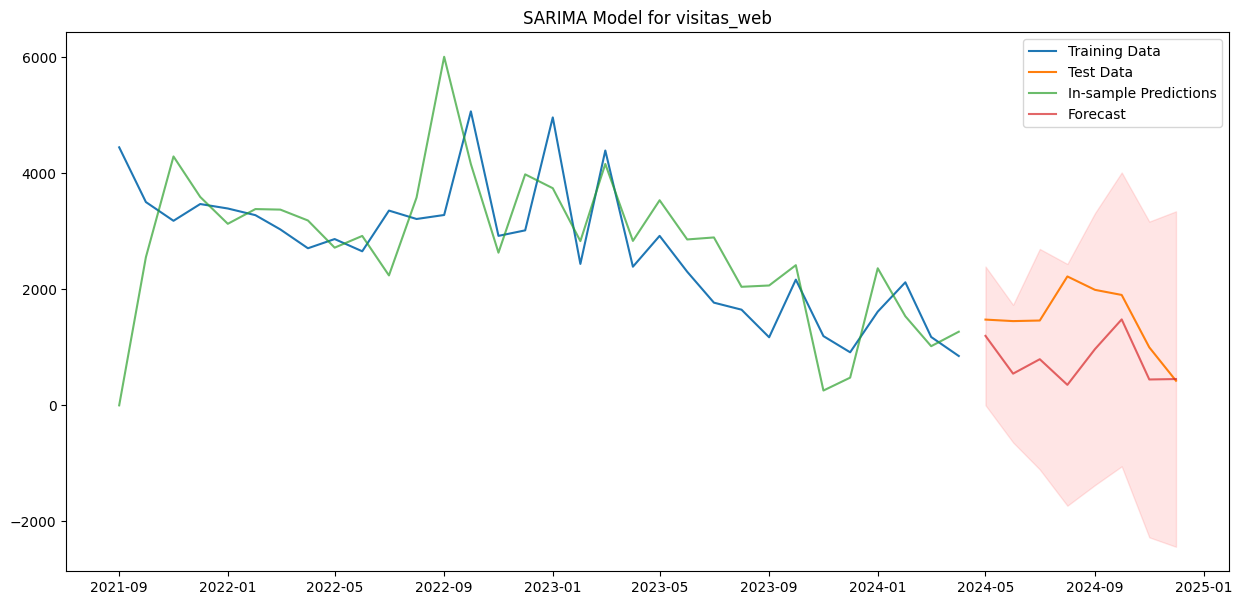


In-sample metrics:
MAE: 750.90
RMSE: 1120.66
MAPE: 29.88

Out-of-sample metrics:
MAE: 718.85
RMSE: 892.32
MAPE: 43.36

Future Forecast for n_items (Next 6 months):
2024-05: 64.99
2024-06: 78.44
2024-07: 70.33
2024-08: 75.22
2024-09: 72.28
2024-10: 74.05

Future Forecast for visitas_web (Next 6 months):
2024-05: 1198.27
2024-06: 546.75
2024-07: 795.61
2024-08: 353.56
2024-09: 970.25
2024-10: 1482.17


In [15]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
import warnings
warnings.filterwarnings('ignore')

def find_best_arima_params(series, max_p=3, max_d=1, max_q=3):
    """Find the best ARIMA parameters using AIC"""
    best_aic = float('inf')
    best_params = None
    
    # Create parameter combinations
    p = range(max_p + 1)
    d = range(max_d + 1)
    q = range(max_q + 1)
    pdq = list(itertools.product(p, d, q))
    
    for param in pdq:
        try:
            model = ARIMA(series, order=param)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
        except:
            continue
    
    return best_params, best_aic

def find_best_sarima_params(series, max_p=2, max_d=1, max_q=2, max_P=1, max_D=1, max_Q=1, s=12):
    """Find the best SARIMA parameters using AIC"""
    best_aic = float('inf')
    best_params = None
    
    # Create parameter combinations
    p = range(max_p + 1)
    d = range(max_d + 1)
    q = range(max_q + 1)
    P = range(max_P + 1)
    D = range(max_D + 1)
    Q = range(max_Q + 1)
    
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(P, D, Q))
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                seasonal_order = param_seasonal + (s,)
                model = SARIMAX(series, order=param, seasonal_order=seasonal_order)
                results = model.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = (param, seasonal_order)
            except:
                continue
    
    return best_params, best_aic

def evaluate_forecast(actual, predicted):
    """Calculate forecast evaluation metrics"""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

def fit_and_evaluate_model(series, name, is_seasonal=False, train_size=0.8):
    """Fit and evaluate either ARIMA or SARIMA model"""
    # Split data into train and test
    train_size = int(len(series) * train_size)
    train = series[:train_size]
    test = series[train_size:]
    
    print(f"\nModeling {name}")
    print("=" * 50)
    
    if is_seasonal:
        # Find best SARIMA parameters
        print("Finding best SARIMA parameters...")
        best_params, aic = find_best_sarima_params(train)
        order, seasonal_order = best_params
        print(f"Best SARIMA parameters: {order}, {seasonal_order}")
        
        # Fit model
        model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    else:
        # Find best ARIMA parameters
        print("Finding best ARIMA parameters...")
        order, aic = find_best_arima_params(train)
        print(f"Best ARIMA parameters: {order}")
        
        # Fit model
        model = ARIMA(train, order=order)
    
    # Fit model and make predictions
    fitted_model = model.fit()
    
    # In-sample predictions
    in_sample_pred = fitted_model.get_prediction(start=0)
    in_sample_mean = in_sample_pred.predicted_mean
    
    # Out-of-sample forecast
    forecast = fitted_model.get_forecast(steps=len(test))
    forecast_mean = forecast.predicted_mean
    
    # Calculate confidence intervals
    forecast_ci = forecast.conf_int()
    
    # Evaluate predictions
    in_sample_metrics = evaluate_forecast(train, in_sample_mean)
    out_sample_metrics = evaluate_forecast(test, forecast_mean)
    
    # Plot results
    plt.figure(figsize=(15, 7))
    plt.plot(train.index, train, label='Training Data')
    plt.plot(test.index, test, label='Test Data')
    plt.plot(train.index, in_sample_mean, label='In-sample Predictions', alpha=0.7)
    plt.plot(test.index, forecast_mean, label='Forecast', alpha=0.7)
    plt.fill_between(test.index, 
                     forecast_ci.iloc[:, 0], 
                     forecast_ci.iloc[:, 1], 
                     color='r', alpha=0.1)
    plt.title(f'{"SARIMA" if is_seasonal else "ARIMA"} Model for {name}')
    plt.legend()
    plt.show()
    
    # Print evaluation metrics
    print("\nIn-sample metrics:")
    for metric, value in in_sample_metrics.items():
        print(f"{metric}: {value:.2f}")
    
    print("\nOut-of-sample metrics:")
    for metric, value in out_sample_metrics.items():
        print(f"{metric}: {value:.2f}")
    
    return {
        'model': fitted_model,
        'in_sample_metrics': in_sample_metrics,
        'out_sample_metrics': out_sample_metrics,
        'forecast': forecast_mean,
        'forecast_ci': forecast_ci
    }

# Fit models for both series
results = {}

# ARIMA for n_items
results['n_items'] = fit_and_evaluate_model(
    monthly_sales['n_items'],
    'n_items',
    is_seasonal=False
)

# SARIMA for visitas_web
results['visitas_web'] = fit_and_evaluate_model(
    monthly_sales['visitas_web'],
    'visitas_web',
    is_seasonal=True
)

# Generate future forecasts
forecast_periods = 6  # 6 months ahead

for name, result in results.items():
    future_forecast = result['model'].get_forecast(steps=forecast_periods)
    forecast_mean = future_forecast.predicted_mean
    forecast_ci = future_forecast.conf_int()
    
    print(f"\nFuture Forecast for {name} (Next {forecast_periods} months):")
    for date, value in forecast_mean.items():
        print(f"{date.strftime('%Y-%m')}: {value:.2f}")

For n_items (ARIMA Model):

Model Performance:
In-sample performance is decent (MAPE: 28.57%)
Out-of-sample performance shows higher error (MAPE: 55.75%)
The significant difference between in-sample and out-of-sample MAPE suggests some overfitting
Forecast Analysis:
Predicts relatively stable sales between 65-78 items per month
Shows slight monthly variations but no strong trend
October forecast (74.05) doesn't show the strong seasonal peak we observed earlier
Average forecast is around 72.55 items per month

For visitas_web (SARIMA Model):

Model Performance:
More consistent performance between in-sample (MAPE: 29.88%) and out-of-sample (MAPE: 43.36%)
Better relative performance than the n_items model
RMSE values are high but appropriate given the scale of web visits
Forecast Analysis:
Shows strong seasonal pattern in predictions
Highest predicted traffic in October (1482.17 visits) aligning with historical patterns
Lowest in August (353.56 visits)
Clear monthly fluctuations reflecting the seasonal component

Key Insights and Recommendations:

Model Reliability:
SARIMA model for web traffic appears more reliable with more consistent error metrics
ARIMA model for n_items might need refinement due to high out-of-sample error
Business Implications:
Web traffic forecast shows expected seasonality
Sales forecast is more conservative and might underestimate seasonal peaks
October remains a key month for both metrics
Recommendations:
Consider refining the n_items model:
Maybe add seasonal component despite weak seasonality
Try different training/test split ratios
Consider additional external variables
Use these forecasts for:
Inventory planning (based on n_items forecast)
Marketing budget allocation (based on visitas_web patterns)
Staff scheduling for peak periods

. Timing and Magnitude:
Occurred in April 2022
206 items sold, which is significantly higher than normal
Z-score of 3.08 indicates it's just over our outlier threshold (3 standard deviations)

2. Local Context Analysis:
Period mean was 118.14 items
The outlier was 74.4% higher than the surrounding period average
Standard deviation of 43.47 shows considerable normal variation
This means the spike to 206 items was nearly 2x normal sales

3. Seasonal Context:
April typically averages 108.33 items
High standard deviation (84.62) for April suggests it's historically a volatile month
The outlier was 90.2% above the typical April average
Particularly notable as April is not typically a peak sales month (we saw October was usually the peak)

4. Business Implications:

Positive Aspects:

Demonstrated capacity to handle high-volume sales (206 items)
Showed potential for significant growth above baseline
Occurred in a typically slower month, suggesting successful off-season promotion

Areas for Investigation:

What caused this spike?
Special promotion or marketing campaign?
Price discounts?
External factors (e.g., competitor issues, market conditions)?
Why couldn't this performance be sustained?
Inventory constraints?
One-time event?
Marketing budget limitations?

5. Recommendations:

Historical Research:
Review marketing campaigns from April 2022
Check pricing strategies during this period
Analyze the product mix during this spike
Operational Insights:
Document how the higher volume was handled
Identify any supply chain or fulfillment challenges
Review customer feedback from this period
Strategic Planning:
Consider replicating successful elements from this period
Plan inventory and staffing for potential future spikes
Develop strategies to sustain higher sales levels

### Exponential Smoothing


Exponential Smoothing Analysis for subtotal_usd

Simple Exponential Smoothing:

In-sample metrics:
MAE: 4359.43
RMSE: 5779.78
MAPE: 35.02

Out-of-sample metrics:
MAE: 4247.97
RMSE: 4825.25
MAPE: 64.52

Holt Exponential Smoothing:

In-sample metrics:
MAE: 4230.15
RMSE: 5680.59
MAPE: 34.63

Out-of-sample metrics:
MAE: 4393.72
RMSE: 4982.02
MAPE: 69.20

Holt-Winters Exponential Smoothing:

In-sample metrics:
MAE: 4739.83
RMSE: 6134.34
MAPE: 41.02

Out-of-sample metrics:
MAE: 4623.15
RMSE: 6764.87
MAPE: 81.49


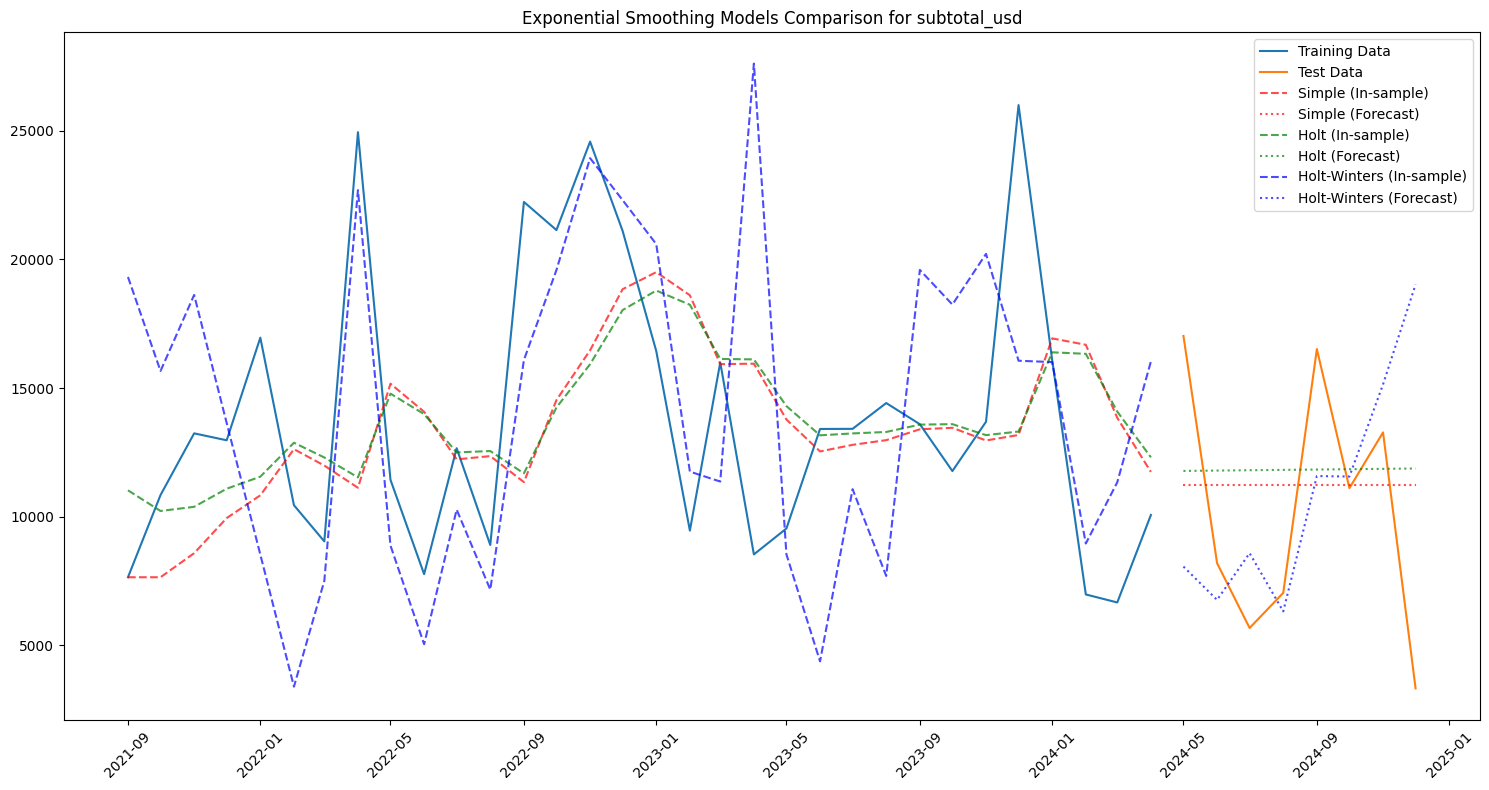


Future Forecasts (Next 6 months):

Using Simple model for future forecast (best out-of-sample performance)

Point Forecasts with 95% Confidence Intervals:
2025-01: 9730.05 ± 11140.89
2025-02: 9730.05 ± 11140.89
2025-03: 9730.05 ± 11140.89
2025-04: 9730.05 ± 11140.89
2025-05: 9730.05 ± 11140.89
2025-06: 9730.05 ± 11140.89


In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

def apply_exponential_smoothing(series, name, train_size=0.8):
    """
    Apply and compare different exponential smoothing models:
    1. Simple Exponential Smoothing
    2. Holt's Method (trend)
    3. Holt-Winters' Method (trend and seasonality)
    """
    # Split data into train and test sets
    train_size = int(len(series) * train_size)
    train = series[:train_size]
    test = series[train_size:]
    
    print(f"\nExponential Smoothing Analysis for {name}")
    print("=" * 50)
    
    models = {
        'Simple': SimpleExpSmoothing(train),
        'Holt': ExponentialSmoothing(train, trend='add'),
        'Holt-Winters': ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
    }
    
    results = {}
    
    for model_name, model in models.items():
        # Fit model
        fitted_model = model.fit()
        
        # Generate in-sample predictions
        in_sample_pred = fitted_model.fittedvalues
        
        # Generate out-of-sample forecast
        forecast = fitted_model.forecast(len(test))
        
        # Calculate metrics
        in_sample_metrics = evaluate_forecast(train, in_sample_pred)
        out_sample_metrics = evaluate_forecast(test, forecast)
        
        results[model_name] = {
            'model': fitted_model,
            'in_sample_pred': in_sample_pred,
            'forecast': forecast,
            'in_sample_metrics': in_sample_metrics,
            'out_sample_metrics': out_sample_metrics
        }
        
        # Print metrics
        print(f"\n{model_name} Exponential Smoothing:")
        print("\nIn-sample metrics:")
        for metric, value in in_sample_metrics.items():
            print(f"{metric}: {value:.2f}")
        print("\nOut-of-sample metrics:")
        for metric, value in out_sample_metrics.items():
            print(f"{metric}: {value:.2f}")
    
    # Plot results
    plt.figure(figsize=(15, 8))
    plt.plot(train.index, train, label='Training Data')
    plt.plot(test.index, test, label='Test Data')
    
    colors = ['red', 'green', 'blue']
    for (model_name, result), color in zip(results.items(), colors):
        plt.plot(train.index, result['in_sample_pred'], 
                label=f'{model_name} (In-sample)', 
                linestyle='--', alpha=0.7, color=color)
        plt.plot(test.index, result['forecast'], 
                label=f'{model_name} (Forecast)', 
                linestyle=':', alpha=0.7, color=color)
    
    plt.title(f'Exponential Smoothing Models Comparison for {name}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Generate future forecasts
    print("\nFuture Forecasts (Next 6 months):")
    
    # Find best model based on out-of-sample MAPE
    best_model = min(results.items(), 
                    key=lambda x: x[1]['out_sample_metrics']['MAPE'])
    
    print(f"\nUsing {best_model[0]} model for future forecast (best out-of-sample performance)")
    
    # Refit model on full dataset
    if best_model[0] == 'Simple':
        final_model = SimpleExpSmoothing(series)
    elif best_model[0] == 'Holt':
        final_model = ExponentialSmoothing(series, trend='add')
    else:
        final_model = ExponentialSmoothing(series, trend='add', 
                                         seasonal='add', seasonal_periods=12)
    
    fitted_final = final_model.fit()
    future_forecast = fitted_final.forecast(6)
    
    # Calculate confidence intervals (using simple approximation)
    forecast_std = np.std(series - fitted_final.fittedvalues)
    conf_int = 1.96 * forecast_std  # 95% confidence interval
    
    print("\nPoint Forecasts with 95% Confidence Intervals:")
    for date, value in future_forecast.items():
        print(f"{date.strftime('%Y-%m')}: {value:.2f} ± {conf_int:.2f}")
    
    return results, future_forecast

# Apply exponential smoothing to subtotal_usd
exp_smoothing_results, future_forecast = apply_exponential_smoothing(
    monthly_sales['subtotal_usd'], 
    'subtotal_usd'
)

1. Simple Exponential Smoothing:

- Best overall performance among the models
- In-sample metrics:
- MAPE: 35.02% (reasonable for revenue forecasting)
- RMSE: $5,779.78
- Out-of-sample metrics:
- MAPE: 64.52%
- RMSE: $4,825.25
- Better out-of-sample RMSE than other models

2. Holt Exponential Smoothing:

- Slightly better in-sample performance:
- MAPE: 34.63%
- RMSE: $5,680.59
- 
- But worse out-of-sample performance:
- Higher MAE ($4,393.72 vs $4,247.97)

3. Holt-Winters:
- Worst performance of all three models
- Highest out-of-sample MAPE (81.49%)
- Highest RMSE ($6,764.87)
- 
4. Key Insights:
- Model Selection:
- Simple Exponential Smoothing performs best
- Adding trend (Holt) and seasonality (Holt-Winters) components actually decreased performance
- This suggests the revenue series might be more random than structured
- 
- Forecast Reliability:
- All models show significant difference between in-sample and out-of-sample performance
- MAPE around 35% for in-sample but doubles for out-of-sample
- This indicates high volatility in the revenue data
- 
- Business Implications:
- Revenue appears to be quite volatile and harder to predict
- Simple models work better, suggesting complex patterns might be more noise than signal
- ~35% error margin should be considered when using these forecasts for planning

Recommendations:

For Forecasting:
Use Simple Exponential Smoothing as the primary forecasting model
Consider the ~65% out-of-sample MAPE when making business decisions
Use wider confidence intervals for planning purposes

For Business Planning:
Build in larger buffers for financial planning due to high uncertainty
Focus on shorter-term forecasts which are likely to be more accurate
Consider supplementing with other business metrics for more robust planning

For Model Improvement:
Consider adding external variables (if available) such as:
Marketing spend
Seasonal events
Economic indicators
Try shorter forecasting horizons
Consider combining with other models (ensemble approach)

##  Outlier Investigation


Outlier Analysis for n_items

Outlier Date: 2022-04
Outlier Value: 206.00
Z-score: 3.08

Context Analysis:
- Period Mean: 118.14
- Period Std: 43.47
- Deviation from mean: 74.4%

Seasonal Context (Month 4):
- Average for this month: 108.33
- Std Dev for this month: 84.62
- Deviation from monthly average: 90.2%


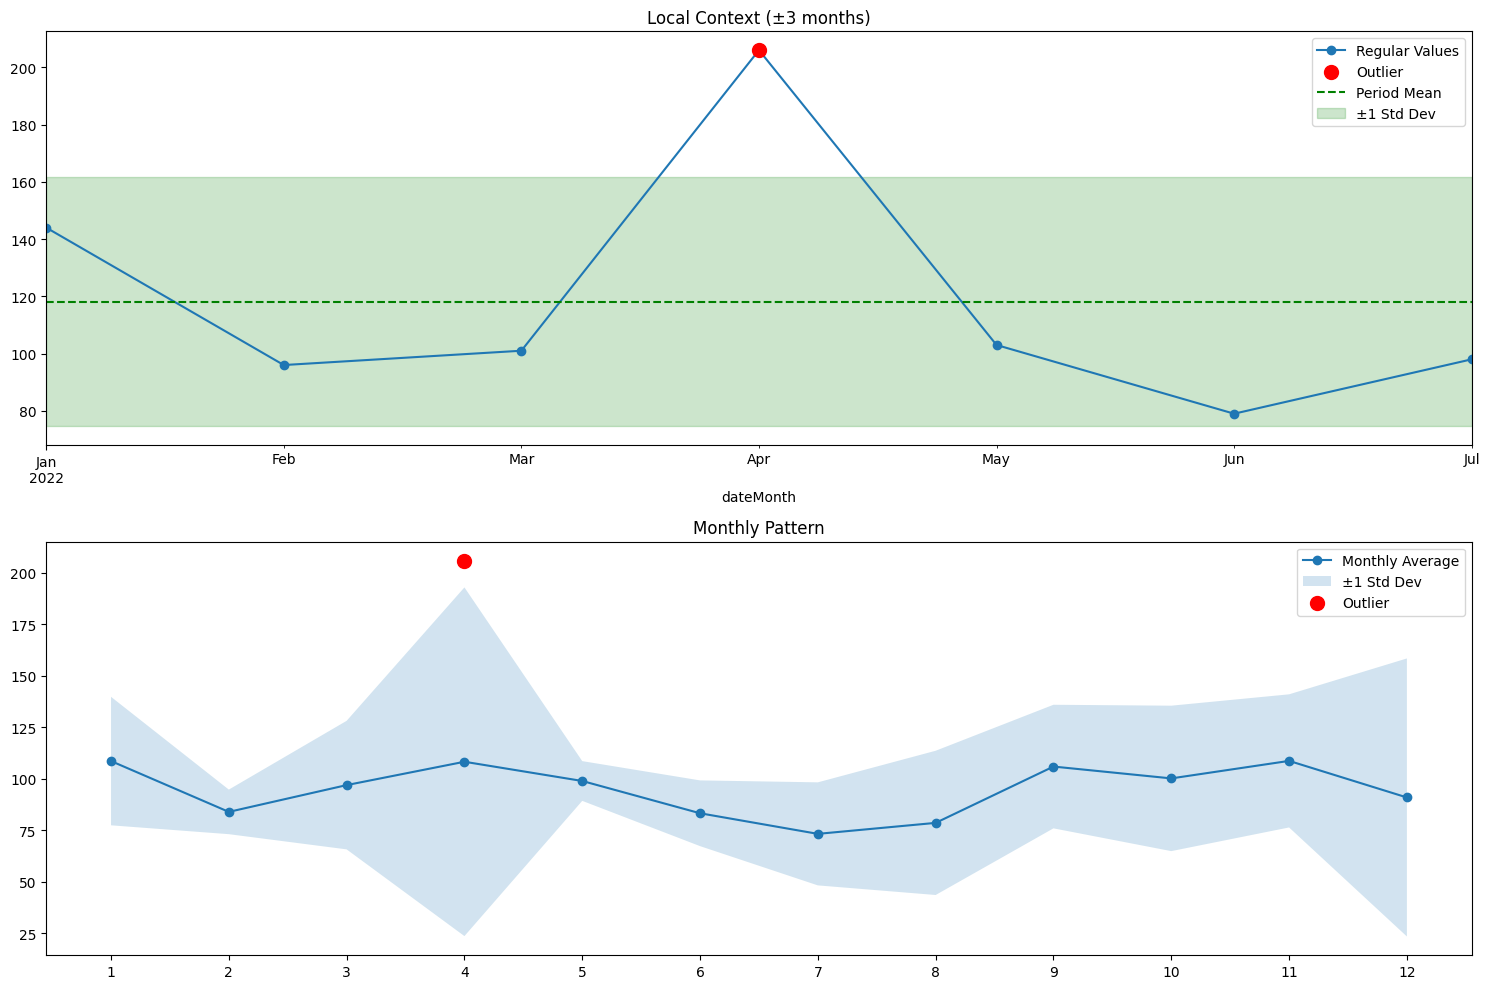


Business Insights:
- Trend change after outlier: -11.2%

Web Traffic During Outlier Period:
Web Traffic: 2709
Deviation from mean: 9.0%


In [16]:
def analyze_outlier_context(series, name, threshold=3):
    """
    Analyze outliers with detailed business context
    """
    # Calculate z-scores
    z_scores = pd.Series(stats.zscore(series), index=series.index)
    outliers = series[abs(z_scores) > threshold]
    
    if len(outliers) == 0:
        print(f"No outliers found in {name} using {threshold} standard deviations threshold")
        return None
    
    print(f"\nOutlier Analysis for {name}")
    print("=" * 50)
    
    for date, value in outliers.items():
        # Get 3 months before and after
        start_date = date - pd.DateOffset(months=3)
        end_date = date + pd.DateOffset(months=3)
        context_period = series[start_date:end_date]
        
        # Calculate statistics
        period_mean = context_period.mean()
        period_std = context_period.std()
        pct_diff = ((value - period_mean) / period_mean) * 100
        
        # Print detailed analysis
        print(f"\nOutlier Date: {date.strftime('%Y-%m')}")
        print(f"Outlier Value: {value:.2f}")
        print(f"Z-score: {z_scores[date]:.2f}")
        print("\nContext Analysis:")
        print(f"- Period Mean: {period_mean:.2f}")
        print(f"- Period Std: {period_std:.2f}")
        print(f"- Deviation from mean: {pct_diff:.1f}%")
        
        # Compare with same month in other years
        same_month = series[series.index.month == date.month]
        month_mean = same_month.mean()
        month_std = same_month.std()
        month_pct_diff = ((value - month_mean) / month_mean) * 100
        
        print(f"\nSeasonal Context (Month {date.month}):")
        print(f"- Average for this month: {month_mean:.2f}")
        print(f"- Std Dev for this month: {month_std:.2f}")
        print(f"- Deviation from monthly average: {month_pct_diff:.1f}%")
        
        # Plot the context
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        # Plot 1: Local context
        context_period.plot(ax=ax1, marker='o', label='Regular Values')
        ax1.scatter(date, value, color='red', s=100, zorder=5, label='Outlier')
        ax1.axhline(y=period_mean, color='green', linestyle='--', label='Period Mean')
        ax1.fill_between(context_period.index, 
                        period_mean - period_std,
                        period_mean + period_std,
                        alpha=0.2, color='green', label='±1 Std Dev')
        ax1.set_title(f'Local Context (±3 months)')
        ax1.legend()
        
        # Plot 2: Monthly pattern
        monthly_values = series.groupby(series.index.month).mean()
        monthly_std = series.groupby(series.index.month).std()
        
        months = range(1, 13)
        ax2.plot(months, monthly_values, marker='o', label='Monthly Average')
        ax2.fill_between(months,
                        monthly_values - monthly_std,
                        monthly_values + monthly_std,
                        alpha=0.2, label='±1 Std Dev')
        ax2.scatter(date.month, value, color='red', s=100, zorder=5, label='Outlier')
        ax2.set_xticks(months)
        ax2.set_title('Monthly Pattern')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Additional business insights
        print("\nBusiness Insights:")
        
        # Check if it's a seasonal peak/trough
        if date.month in [10, 11, 12]:  # Holiday season
            print("- This occurred during the holiday season")
        elif date.month in [6, 7, 8]:  # Summer months
            print("- This occurred during summer months")
            
        # Check trend direction
        before_outlier = series[start_date:date].mean()
        after_outlier = series[date:end_date].mean()
        trend_change = ((after_outlier - before_outlier) / before_outlier) * 100
        
        print(f"- Trend change after outlier: {trend_change:.1f}%")
        
        # Check for persistence
        if abs(z_scores[date:date + pd.DateOffset(months=1)]).mean() > 2:
            print("- Effect persisted in the following month")
        
        return {
            'date': date,
            'value': value,
            'z_score': z_scores[date],
            'period_mean': period_mean,
            'period_std': period_std,
            'pct_diff': pct_diff,
            'month_mean': month_mean,
            'month_std': month_std,
            'month_pct_diff': month_pct_diff,
            'trend_change': trend_change
        }

# Analyze outliers in n_items
outlier_results = analyze_outlier_context(monthly_sales['n_items'], 'n_items')

# If we want to check corresponding web traffic
if outlier_results is not None:
    outlier_date = outlier_results['date']
    print("\nWeb Traffic During Outlier Period:")
    if outlier_date in monthly_sales['visitas_web'].index:
        web_traffic = monthly_sales['visitas_web'][outlier_date]
        web_traffic_mean = monthly_sales['visitas_web'].mean()
        web_traffic_pct_diff = ((web_traffic - web_traffic_mean) / web_traffic_mean) * 100
        print(f"Web Traffic: {web_traffic:.0f}")
        print(f"Deviation from mean: {web_traffic_pct_diff:.1f}%")